# Quantitative sensitivity analysis

Here we show how to compute generalized Sobol indices on the **EOQ** model using the algorithm presented in Kucherenko et al. 2012.

We import our model function from ``temfpy`` and use the Kucherenko indices function from ``econsa``. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from functools import partial

from temfpy.uncertainty_quantification import eoq_model
from econsa.kucherenko import kucherenko_indices

## Theory

If you already know enough about the theory of Sobol indices and only care to learn how to use our supported functions, feel free to skip this part and go to chapter *Computation*.

When analyzing (complex) computational models it is often unclear from the model specification alone how the inputs of the model contribute to the outputs. As we've seen in the previous tutorial on *Qualitative sensitivity analysis*, a first step is to sort the inputs by their respective order of importance on the outputs. In many cases however, we would like to learn by how much the individual inputs contribute to the output in relation to the other inputs. This can be done using Sobol and generalized Sobol indices. Classical Sobol indices are designed to work on models with independent input variables; however, since in economics this independence assumption would be very questionable, we focus on so called generalized Sobol indices, as those proposed by Kucherenko et al. 2012, that also work in the case of dependent inputs.

### Abstract definition

Say we have a model $\mathcal{M}:\mathbb{R}^n \to \mathbb{R}, x \mapsto \mathcal{M}(x)$ and we are interested in analyzing the variance of its output on a given subset $U \subset \mathbb{R}^n$, i.e. we want to analyze

$$D := \text{Var}(\mathcal{M}|_U) := \int_U (\mathcal{M}(x) - \mu_U)^2 f_X(x) \mathrm{d}x \,,$$

where $\mu_U := \int_U \mathcal{M}(x) f_X(x) \mathrm{d}x$ denotes the restricted mean of the model and $f_X$ denotes the probability density function imposed on the input parameters.

For the sake of brevity let us assume that $\mathcal{M}$ is already restricted so that we can drop the dependence on $S$.
To analyze the effect of a single variable, or more general a subset of variable, consider partitioning the model inputs as $(y, z) = x$.
The construction of Sobol and generalized Sobol indices starts with noticing that we can decompose the overall variance as

$$D = \text{Var}_y(\mathbb{E}_z\left[\mathcal{M}(y, z) \mid y \right]) + \mathbb{E}_y\left[\text{Var}_z(\mathcal{M}(y, z) \mid y)\right] \,,$$

which implies that
$$1 = \frac{\text{Var}_y(\mathbb{E}_z\left[\mathcal{M}(y, z) \mid y \right])}{D} + \frac{\mathbb{E}_y\left[\text{Var}_z(\mathcal{M}(y, z) \mid y)\right]}{D} =: S_y + S_z^T \,.
$$

We call $S_y$ the *first order effect index* of the subset $y$ and we call $S_z^T$ the *total effect* of the subset $z$.
Notice that for each partition of the input space $y$ and $z$, the above provides a way of computing the fraction of explained variance.

### Interpretation

For the sake of clarity, assume $y$ represent only a single input variable. Then $S_y$ can be interpreted as the effect of $y$ on the variability of $\mathcal{M}$ **without** considering any interaction effects with other variables. While $S_y^T$ can be thought of as representing the effect of $y$ on the variance via itself **and** all other input variables.

## Computation

The function ``kucherenko_indices`` expects the input function to be broadcastable over rows, that is, a row represents the input arguments for one evaluation.

For sampling around the mean parameters we specify a diagonal covariance matrix, where the variances depend on the scaling of the mean. Since the variances of the parameters are unknown prior to our analysis we choose values such that the probability of sampling negative values is negligible. We do this since the **EOQ** model is not defined for negative parameters and the normal sampling does not naturally account for bounds.

In [2]:
def eoq_model_transposed(x):
    """EOQ Model but with variables stored in columns."""
    return eoq_model(x.T)


mean = np.array([1230, 0.0135, 2.15])
cov = np.diag([1, 0.000001, 0.01])

indices = kucherenko_indices(
    func=eoq_model_transposed,
    sampling_mean=mean,
    sampling_cov=cov,
    n_draws=1_000_000,
    sampling_scheme="sobol",
)

indices

value
var type                 
0   first_order  0.000251
    total        0.000085
1   first_order  0.720977
    total        0.721456
2   first_order  0.278407
    total        0.278851

## Convergence check

To validate convergence we run the function for multiple number of draws and plot the resulting series.

In [3]:
# partial out all arguments besides n_draws
kucherenko = partial(
    kucherenko_indices,
    func=eoq_model_transposed,
    sampling_mean=mean,
    sampling_cov=cov,
    sampling_scheme="sobol",
)


def kucherenko_path(n_draws_list):
    """Compute Kucherenko indices for various number of draws."""
    data = {n: kucherenko(n_draws=n) for n in n_draws_list}
    df = pd.concat(data, names=["n_draws"])
    return df

In [4]:
n_draws_list = sum(
    [[10 ** n, 2 * 10 ** n, 5 * 10 ** n] for n in range(2, 6)], []
)
n_draws_list

[100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000]

In [5]:
path = kucherenko_path(n_draws_list)
path.reset_index(inplace=True)
path["var"] = path["var"].map({0: "M", 1: "C", 2: "S"})

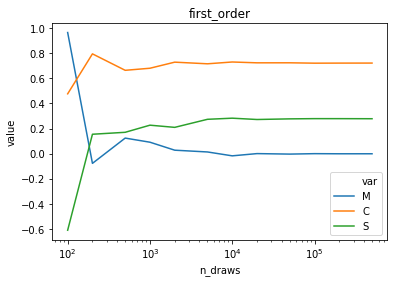

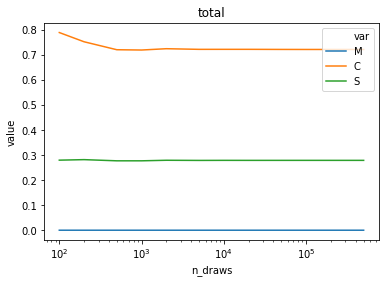

In [6]:
for typ in ["first_order", "total"]:
    sns.lineplot(
        y="value", x="n_draws", hue="var", data=path.query(f"type=='{typ}'")
    )
    plt.xscale("log")
    plt.title(typ)
    plt.show()

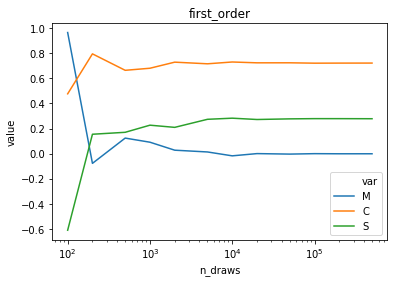

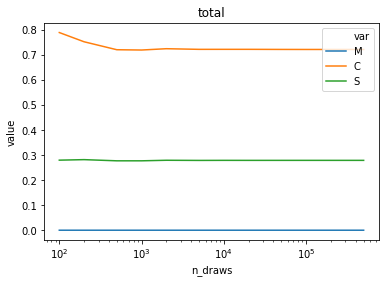

In [7]:
for typ in ["first_order", "total"]:
    sns.lineplot(
        y="value", x="n_draws", hue="var", data=path.query(f"type=='{typ}'")
    )
    plt.xscale("log")
    plt.title(typ)
    plt.show()